In [1]:
import os
import cv2
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import matplotlib
import splitfolders
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import applications
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.layers import Input, Conv2D, Activation, BatchNormalization, MaxPooling2D, concatenate, Dropout, GlobalAveragePooling2D, Dense, Reshape, Multiply, Lambda
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import label_binarize
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix, precision_recall_curve

# Data Split

In [ ]:
# splitfolders.ratio(input=r"./Rice_Image_Dataset",
#                    output=r"./datasets",
#                    seed=1337,
#                    ratio=(0.7, 0.15, 0.15))

# Data Preprocessing (Image Enhancements)

In [2]:
batch_size= 16
data = "./datasets"

# Load and preprocess the dataset
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    os.path.join(data, 'train'),
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical'
)

image_datagen = ImageDataGenerator(rescale=1.0/255)

val_generator = image_datagen.flow_from_directory(
    os.path.join(data, 'val'),
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = image_datagen.flow_from_directory(
    os.path.join(data, 'test'),
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Extract category information
classes = train_generator.class_indices  
classes_index = dict((v,k) for k,v in classes.items())
print('The index for each category is: ',classes_index)

Found 52500 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.
The index for each category is:  {0: 'Arborio', 1: 'Basmati', 2: 'Ipsala', 3: 'Jasmine', 4: 'Karacadag'}


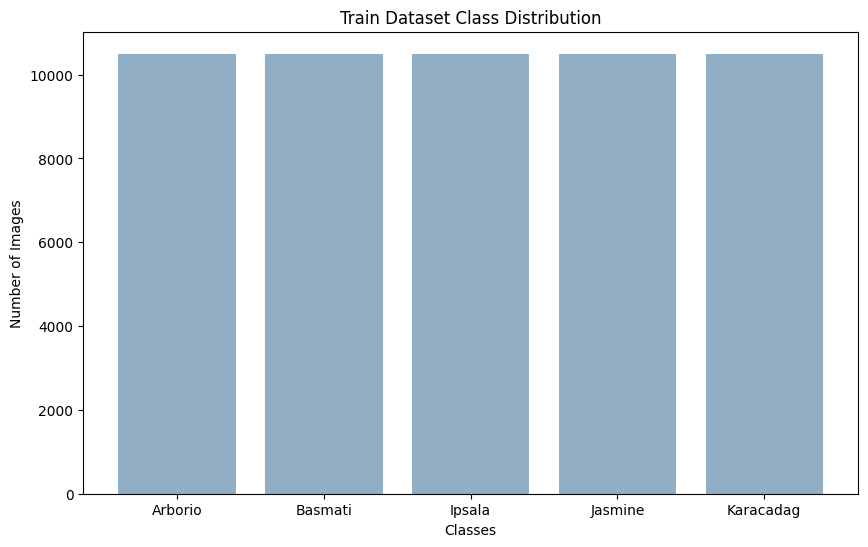

In [3]:
# Get the number of images in each class for training set
train_class_counts = train_generator.classes
train_class_labels = list(train_generator.class_indices.keys())
train_class_counts = [list(train_class_counts).count(i) for i in range(len(train_class_labels))]

plt.figure(figsize=(10, 6))
plt.bar(train_class_labels, train_class_counts, color=['#92aec5'])
plt.title('Train Dataset Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()

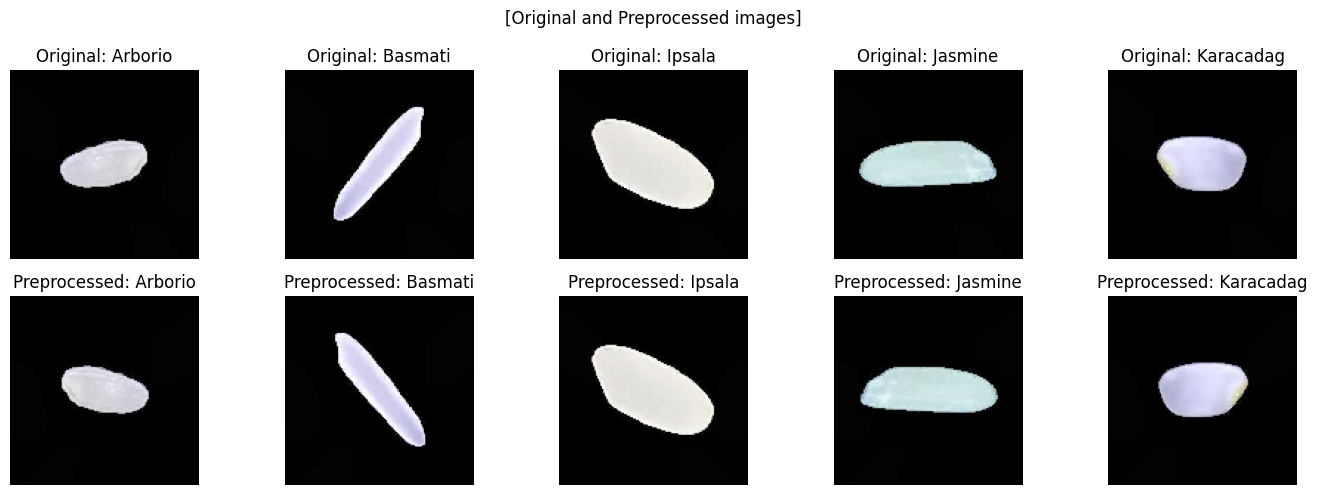

In [4]:
# Randomly select one image from each class
selected_images = []

for class_name in classes_index.values():
    class_path = os.path.join(data, 'train', class_name)
    random_image = random.choice(os.listdir(class_path))
    selected_images.append(os.path.join(class_path, random_image))

rows, cols = 2, len(classes)
fig, axs = plt.subplots(rows, cols, figsize=(14, 5))

for i, img_path in enumerate(selected_images, 1):
    class_name = os.path.basename(os.path.dirname(img_path))
    
    # Load the original image
    img_original = image.load_img(img_path, target_size=(128, 128))
    img_array_original = img_to_array(img_original)
    
    # Use the train_datagen to preprocess the original image
    img_array_preprocessed = train_datagen.random_transform(img_array_original)
 
    plt.subplot(rows, cols, i)
    plt.imshow(image.array_to_img(img_array_original))
    plt.title(f"Original: {class_name}")
    plt.axis('off')
    
    plt.subplot(rows, cols, i + cols)
    plt.imshow(image.array_to_img(img_array_preprocessed))
    plt.title(f"Preprocessed: {class_name}")
    plt.axis('off')

fig.suptitle('[Original and Preprocessed images]')
plt.tight_layout()
plt.show()

In [5]:
l2_reg = tf.keras.regularizers.l2(l2=0.0001)

In [6]:
def SEAttention(x, channels, reduction=16):
    squeeze = GlobalAveragePooling2D()(x)
    
    # Excitation block
    excitation = Sequential([
        Dense(channels // reduction, activation='relu', kernel_regularizer=l2_reg),
        Dense(channels, activation='sigmoid', kernel_regularizer=l2_reg),
        Reshape((1, 1, channels))
    ])(squeeze)
    
    # Element-wise multiplication
    scaled = Multiply()([x, excitation])

    return scaled

In [7]:
def categorical_loss(y_true, y_pred, label_smoothing=0.1):
    epsilon = K.epsilon()
    
    y_true_smoothed = y_true * (1.0 - label_smoothing) + label_smoothing / num_classes
    y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
    
    cce = -tf.reduce_sum(y_true_smoothed * tf.math.log(y_pred), axis=-1)
    total_loss = tf.reduce_mean(cce)
    
    return total_loss

In [8]:
def accuracy(y_true, y_pred, threshold=0.5):
    y_pred_thresholded = tf.cast(y_pred > threshold, tf.float32)
    
    correct_predictions = tf.equal(y_true, tf.round(y_pred_thresholded))
    total_accuracy = tf.reduce_mean(tf.cast(tf.reduce_all(correct_predictions, axis=-1), tf.float32))
    
    return total_accuracy

# TreeCNN

In [9]:
num_classes = len(classes)
input_tensor = Input(shape=(128, 128, 3), name='input_tensor')

def conv1x1(input_tensor, filters):
    return Conv2D(filters, (1, 1), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2_reg)(input_tensor)

def make_branch(input_tensor, filters, num_layers):
    # Convolutional Blocks
    for _ in range(num_layers):
        conv = Conv2D(filters, kernel_size=(3, 3), kernel_regularizer=l2_reg,
                      padding='same', kernel_initializer='he_normal')(input_tensor)
        norm = BatchNormalization()(conv)
        act = Activation('relu')(norm)
        input_tensor = act
    
    # 1x1 Convolution layers for dimension reduction
    conv_reduced = conv1x1(input_tensor, filters)
    
    se_att = SEAttention(conv_reduced, filters)
    
    dropout = Dropout(0.3)(se_att)

    return dropout

def tree_cnn():
    branch1 = make_branch(input_tensor, filters=8, num_layers=1)
    branch2 = make_branch(input_tensor, filters=16, num_layers=2)
    
    # Concatenate branches
    concatenated_branches = concatenate([branch1, branch2], axis=-1)
    concatenated_branches = Dropout(0.3)(concatenated_branches)
    
    conv1 = Conv2D(16, kernel_size=(3, 3), padding='same',kernel_regularizer=l2_reg, kernel_initializer='he_normal')(concatenated_branches)
    norm1 = BatchNormalization()(conv1)
    act1 = Activation('relu')(norm1)
    
    conv2 = Conv2D(32, kernel_size=(3, 3), padding='same',kernel_regularizer=l2_reg, kernel_initializer='he_normal')(act1)
    norm2 = BatchNormalization()(conv2)
    act2 = Activation('relu')(norm2)
    
    norm_branches_reduced = BatchNormalization()(act2)

    global_avg_pooling = GlobalAveragePooling2D()(norm_branches_reduced)

    output = Dense(num_classes, activation='softmax',kernel_initializer='he_normal', kernel_regularizer=l2_reg)(global_avg_pooling)

    model = Model(inputs=input_tensor, outputs=output)
    
    return model

TreeCNN = tree_cnn()
TreeCNN.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_tensor (InputLayer)   [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 128, 128, 16)         448       ['input_tensor[0][0]']        
                                                                                                  
 batch_normalization_1 (Bat  (None, 128, 128, 16)         64        ['conv2d_2[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_1 (Activation)   (None, 128, 128, 16)         0         ['batch_normalization_1[0]

                                                                                                  
Total params: 12150 (47.46 KB)
Trainable params: 11910 (46.52 KB)
Non-trainable params: 240 (960.00 Byte)
__________________________________________________________________________________________________


In [ ]:
plot_model(TreeCNN, show_shapes=True, show_layer_names=True)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
    verbose=1      
)

lr = 0.0001
TreeCNN.compile(optimizer= Adam(learning_rate=lr),
                loss = categorical_loss,
                metrics = [accuracy])

history = TreeCNN.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs= 20,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stopping]
)

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = TreeCNN.evaluate(test_generator)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

In [ ]:
# Save the trained model
TreeCNN.save('TreeCNN.h5')

In [ ]:
tree = load_model('TreeCNN.h5', custom_objects={'accuracy': accuracy,'categorical_loss': categorical_loss})

# LinearCNN

In [ ]:
num_classes = len(classes) 
input_tensor = Input(shape=(128, 128, 3), name='input_tensor')

def block(input_tensor, filters, block_number, num_conv_layers=2):
    x = input_tensor
    
    for i in range(num_conv_layers):
        x = Conv2D(filters, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2_reg)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(0.3)(x)
    
    # Implement SE Attention in the pooling layer to replace max pooling
    se_attention_pooled = SEAttention(x, filters, block_number)
    
    return se_attention_pooled

def linear_cnn():
    filters_list = [16, 32, 64]
    num_conv_layers_list = [1, 1, 2]
    
    conv_block1 = block(input_tensor, filters_list[0], 1, num_conv_layers_list[0])
    conv_block2 = block(conv_block1, filters_list[1], 2, num_conv_layers_list[1])
    conv_block3 = block(conv_block2, filters_list[2], 3, num_conv_layers_list[2])

    global_avg_pooling = GlobalAveragePooling2D()(conv_block3)
    
    output = Dense(num_classes, activation='softmax')(global_avg_pooling)
    
    model = Model(inputs=input_tensor, outputs=output)
    return model

LinearCNN = linear_cnn()
LinearCNN.summary()

In [ ]:
plot_model(LinearCNN, show_shapes=True, show_layer_names=True)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
    verbose=1      
)

lr = 0.0001
LinearCNN.compile(optimizer= Adam(learning_rate=lr),
                loss = categorical_loss,
                metrics = [accuracy])

history = LinearCNN.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stopping]
)

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = LinearCNN.evaluate(test_generator)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

In [ ]:
# Save the trained model
LinearCNN.save('LinearCNN.h5')

In [ ]:
linear = load_model('LinearCNN.h5', custom_objects={'accuracy': accuracy,'categorical_loss': categorical_loss})

# Ensemble Model (weighted average)

In [ ]:
input_tensor = Input(shape=(128, 128, 3), name='input_tensor')

tree_output = TreeCNN(input_tensor)
linear_output = LinearCNN(input_tensor)

tree_weight = 0.3
linear_weight = 0.7

weighted_average = Lambda(lambda x: (x[0] * tree_weight) + (x[1] * linear_weight))([tree_output, linear_output])

weighted_average_model = Model(inputs=input_tensor, outputs=weighted_average)
weighted_average_model.summary()

In [ ]:
plot_model(weighted_average_model, show_shapes=True, show_layer_names=True)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
    verbose=1      
)

lr = 0.0001
weighted_average_model.compile(optimizer= Adam(learning_rate=lr),
                               loss = categorical_loss,
                               metrics = [accuracy])

history = weighted_average_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stopping]
)

In [ ]:
# Evaluate on the test set
test_loss, test_accuracy = weighted_average_model.evaluate(test_generator)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

In [ ]:
# Save the trained model
weighted_average_model.save('weighted_average(Ensemble).h5')

In [ ]:
ensemble = load_model('weighted_average(Ensemble).h5', custom_objects={'accuracy': accuracy,'categorical_loss': categorical_loss})

# Pre-trained Model

In [ ]:
from keras.applications import MobileNet

num_classes = 5

base_model = MobileNet(weights=None, include_top=False, input_shape=(128, 128, 3))
out = GlobalAveragePooling2D()(base_model.output)
out = Dense(60, activation='relu')(out)
predictions = Dense(num_classes, activation='softmax')(out)
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
    verbose=1      
)

lr = 0.0001
model.compile(optimizer= Adam(learning_rate=lr),
              loss = categorical_loss,
              metrics = [accuracy])

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stopping]
)

In [ ]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy curves
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

# Loss curves
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()

# ROC-AUC curve

In [ ]:
y_true = test_generator.classes

predictions = ensemble.predict(test_generator, steps=len(test_generator), verbose=1)

y_true_bin = label_binarize(y_true, classes=np.arange(5))

# False Positive Rate, True Positive Rate, AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
plt.figure(figsize=(12, 7))

for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=1, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC curve (Ensemble)')
plt.legend(loc="lower right")
plt.show()

# Sensitivity-Specificity

In [ ]:
def sensitivity_specificity(model, test_dataset): 
    y_true = test_dataset.classes  
    predictions = model.predict(test_dataset, steps=len(test_dataset), verbose=1) 
    
    y_pred = np.argmax(predictions, axis=1) 
    cm = confusion_matrix(y_true, y_pred)  
    sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0]) 
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) 
    result_df = pd.DataFrame({ 'Metric': ['Sensitivity', 'Specificity'], 'Value': [sensitivity, specificity] }) 
    return result_df 

result_df = sensitivity_specificity(ensemble, test_generator) 
print(result_df)

# Confusion Matrix

In [ ]:
def plot_confusion_matrix(val_dataset, model, test_dataset):
    predictions = model.predict(test_dataset, steps=len(test_dataset), verbose=1)
    preds = np.argmax(predictions, axis=1)

    labels = test_dataset.classes
    class_names = list(val_dataset.class_indices.keys())

    cm = confusion_matrix(labels, preds)

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap='Purples')
    plt.colorbar()

    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45)
    plt.yticks(ticks, class_names)

    plt.title('Confusion Matrix (Ensemble)')

    threshold = 4
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i, j]),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > threshold else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label\naccuracy={:0.4f}; misclass={:0.4f}'.format(
        accuracy, misclass
    ))

plot_confusion_matrix(val_generator, ensemble, test_generator)

# PR

In [ ]:
def plot_precision_recall_curve(model, test_dataset):
    y_true = test_dataset.labels

    predictions = model.predict(test_dataset, steps=len(test_dataset), verbose=1)

    precision = dict()
    recall = dict()
    average_precision = dict()

    for i in range(5):
        precision[i], recall[i], _ = precision_recall_curve(y_true == i, predictions[:, i])
        average_precision[i] = auc(recall[i], precision[i])

    fig, ax = plt.subplots(figsize=(12, 7))
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Precision-Recall Curve (Ensemble)')

    for i in range(5):
        ax.plot(recall[i], precision[i], label='PR curve (AP = %0.2f) for label %i' % (average_precision[i], i))

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_precision_recall_curve(ensemble, test_generator)

# Report

In [ ]:
def class_report(val_dataset, model, prediction_data_gen):
    predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
    
    preds = np.argmax(predictions, axis=1)
    labels = val_dataset.classes
    
    names = np.array([i for i in val_dataset.class_indices.keys()])
    report_dict = classification_report(labels, preds, target_names=names, output_dict=True)
    df = pd.DataFrame.from_dict(report_dict).transpose()
    return df

class_report(val_generator, ensemble, test_generator)

# SHAP

In [ ]:
list_images_sample = [
    "C:/Users/ROG/Desktop/Rice_Classification/datasets/train/Arborio/Arborio (1).jpg",
    "C:/Users/ROG/Desktop/Rice_Classification/datasets/train/Basmati/Basmati (1).jpg",
    "C:/Users/ROG/Desktop/Rice_Classification/datasets/train/Ipsala/Ipsala (1).jpg",
    "C:/Users/ROG/Desktop/Rice_Classification/datasets/train/Jasmine/Jasmine (1).jpg",
    "C:/Users/ROG/Desktop/Rice_Classification/datasets/train/Karacadag/Karacadag (1).jpg"
]

model_builder = keras.applications.xception.Xception
img_size = (128, 128)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions
imag = []
last_conv_layer_name = "conv2d_3"

# To Get Image into numpy array
def get_img_array(img_path, size):
    img = load_img(img_path, target_size = size) 
    array = img_to_array(img) 
    array = np.expand_dims(array, axis = 0)
    return array

# Top create heatmaps for the samples
def make_gradcam_heatmap(img_array,model, last_conv_layer_name, pred_index = None):
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Storing Heatmap values into list
covid_noncovid_heatmap = []
for i in list_images_sample:
    img_array = preprocess_input(get_img_array(i, size=img_size))
    model = linear
    model.layers[-1].activation = None
    preds = model.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    covid_noncovid_heatmap.append(heatmap)

# To Display GradCAM output for the samples
def save_and_display_gradcam(img_path, heatmap, cam_path = "cam.jpg", alpha = 0.4):
    img = load_img(img_path)
    img = img_to_array(img)
    heatmap = np.uint8(255 * heatmap)

    jet = matplotlib.colormaps.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    
    imag.append(cv2.imread(img_path))
    imag.append(cv2.imread("./cam.jpg"))

for i in range(len(list_images_sample)):
    save_and_display_gradcam(list_images_sample[i], covid_noncovid_heatmap[i])

def plot_multiple_img(img_matrix_list, title_list, ncols, main_title=""):
    num_images = len(img_matrix_list)
    fig, myaxes = plt.subplots(
        figsize=(15, 5 * (num_images // ncols)), nrows=(num_images + ncols - 1) // ncols, ncols=ncols, squeeze=False
    )
    fig.suptitle(main_title, fontsize=18)
    fig.subplots_adjust(wspace=0.1)
    fig.subplots_adjust(hspace=0.3, top=0.95)  # Adjust the top parameter to reduce the distance

    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        row = i // ncols
        col = i % ncols
        myaxes[row][col].imshow(img)
        myaxes[row][col].set_title(title, fontsize=12)
        myaxes[row][col].axis('off')

    # Remove empty subplots
    for i in range(num_images, len(myaxes.flatten())):
        row = i // ncols
        col = i % ncols
        fig.delaxes(myaxes[row][col])
    plt.show()

titles_list = [
"Arborio", "Arborio CAM",
"Basmati", "Basmati CAM",
"Ipsala", "Ipsala CAM",
"Jasmine", "Jasmine CAM",
"Karacadag", "Karacadag CAM"]

plot_multiple_img(imag, titles_list, ncols=2, main_title="Rice Image Analysis")